In [4]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: base
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [5]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score, RocCurveDisplay

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

ModuleNotFoundError: No module named 'crem'

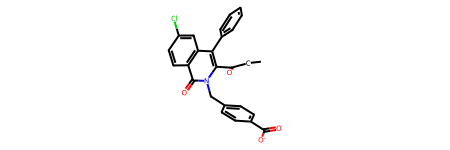

In [ ]:
initial_mol = Chem.MolFromMolFile("data/docking/2zdt_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

initial_mol

In [ ]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

In [ ]:
# Change directory to generate analogs with python script
%cd ..

arg1 = '--input_frag'
arg2 = '--remove_odd_rings'
subprocess.run(['python3', 'generate_analogs.py', arg1, initial, arg2, 'False'],
                 stdout=subprocess.DEVNULL,
                 stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


### REINVENT

In [ ]:
df = pd.read_csv('data/dataframe.csv')

df = df.loc[:, ['SMILES']]
df['Model'] = 'reinvent'

In [ ]:
df = df.sample(500)

df

,SMILES,Model
45,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,reinvent
1059,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
665,CCC(=O)c1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...,reinvent
912,NC(=O)c1ccc(Cn2c(N)c(-c3ccccc3)c3cc(Cl)ccc3c2=...,reinvent
377,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
...,...,...
236,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
1106,CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1cc(...,reinvent
231,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,reinvent
196,CCC(=O)c1c(-c2ccccc2)c2cc(F)ccc2c(=O)n1Cc1ccc(...,reinvent


### CReM

In [ ]:
out_list = []
mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

for idx, analog in enumerate(mutate_list):
    out_list.append([analog])

In [ ]:
temp_df = pd.DataFrame(out_list, columns=["SMILES"])

temp_df['Model'] = 'crem'

In [ ]:
temp_df = temp_df.sample(500)

temp_df

,SMILES,Model
52,CCC(=O)c1c(-c2ccccc2)c2cc(C#N)ccc2c(=O)n1Cc1cc...,crem
428,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
473,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
113,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
513,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
...,...,...
341,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
69,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
410,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
517,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem


In [ ]:
df = pd.concat((df, temp_df))

### Coati

In [ ]:
encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl
Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


In [ ]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
        
    return unique_valid_smiles

In [ ]:
coati_smiles = gen_mol(initial, coati_version = 2, num_variations = 1000, noise_scale = 0.5)

Attempted 1000 COATI2 generations with a noise scale of 0.5 and generated 227 unique structures.


In [ ]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = coati_smiles
temp_df['Model'] = 'coati'

In [ ]:
temp_df

,SMILES,Model
0,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,coati
1,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,coati
2,CCC(=O)c1c(-c2ccc(Cl)cc2)c2cc(Cl)ccc2c(=O)n1Cc...,coati
3,CCCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc...,coati
4,CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(...,coati
...,...,...
222,CCC(=O)C1=C(c2ccccc2)c2cc(Cl)ccc2CN1Cc1ccc(C(=...,coati
223,CC[N+]1=C(c2ccccc2)C(=O)C(C)=Cc2ccc(C(=O)[O-])...,coati
224,CCC(=O)/C([O-])=C(/Cc1ccccc1)C1=Cc2ccc(C(=O)[O...,coati
225,CCC(=O)C(c1ccccc1)c1cc(Cl)c2ccccc2c1Cc1ccc(C(=...,coati


In [ ]:
df = pd.concat((df, temp_df))

### SAFE

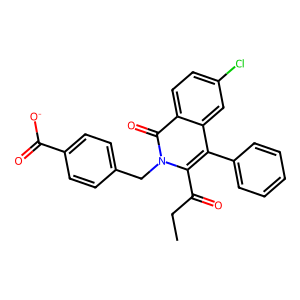

In [ ]:
initial_mol = dm.to_mol(initial)
display(dm.to_image(initial_mol))

In [ ]:
designer = sf.SAFEDesign.load_default(verbose=True)

In [ ]:
%%capture

safe_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=500)

Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

In [ ]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = safe_smiles
temp_df['Model'] = 'safe'

In [ ]:
df = pd.concat((df, temp_df))

In [ ]:
df

,SMILES,Model
45,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,reinvent
1059,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
665,CCC(=O)c1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...,reinvent
912,NC(=O)c1ccc(Cn2c(N)c(-c3ccccc3)c3cc(Cl)ccc3c2=...,reinvent
377,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
...,...,...
471,COCCN1C(=O)CCC1Cc1ccc(OC)cc1,safe
472,O=C(Nc1nn(-c2ccc(F)cc2)c2c1CCC2)c1cc([N+](=O)[...,safe
473,CCOP(=O)(CN1C(=O)c2c3c(c(O)c(F)c2[C@@H]1c1c(Cl...,safe
474,C[C@@H]1C[NH+](Cc2ccccc2)C[C@@H]1CNC(=O)N1CC[C...,safe


In [ ]:
df.to_csv('data/dataframe.csv')

In [ ]:
df = pd.read_csv('data/dataframe.csv')

In [ ]:
y = df['Model'].to_numpy().reshape(-1, 1)

In [ ]:
smiles = df['SMILES'].to_list()

In [ ]:
smiles

['CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(NS(N)(=O)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(C(=O)N2CCOCC2)n(C)n1',
 'CCC(=O)c1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)ccc3c2=O)cc1',
 'NC(=O)c1ccc(Cn2c(N)c(-c3ccccc3)c3cc(Cl)ccc3c2=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(C(=O)NC)n(CCCN(C)C)n1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccccc1S(N)(=O)=O',
 'CCCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)O)cc1',
 'CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Br)ccc3c2=O)n1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(C(=O)NC(C)C)n(CC(F)F)n1',
 'CCC(=O)c1c(-c2cccc(C)c2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(N)=O)cc1',
 'CCNC(=O)n1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)ccc3c2=O)c1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(C(=O)N2CCCCC2)n(C)n1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(C(=O)O)c(OC)nc1C',
 'CCOC(=O)c1c(-c2ccccc2)c2cc(C)ccc2c(=O)n1Cc1ccc(C(=O)O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(S(N)(=O)=O)n(CC(N)=O)n1',
 'CCC

### Evaluating Metrics w/ MolScore

In [ ]:
from molscore import MolScore

In [ ]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')
scores = ms.score(smiles)

Found existing directory, appending current time to distinguish


Found existing rascore-env
Launching server: conda run -n rascore-env python /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/scoring_functions/servers/rascore_server.py --port 8015 --model_path /home/fts_g_ucla_edu/.local/lib/python3.10/site-packages/molscore/data/models/RAScore/XGB_chembl_ecfp_counts/model.pkl


In [ ]:
# Once finished
metrics = ms.compute_metrics(
    endpoints=None, # Optional list: by default will use the running final score/reward value
    thresholds=None,  # Optional list: if specified will calculate the yield of molecules above that threshold 
    # chemistry_filters_basic=False,  # Optional, bool: Additionally re-calculate metrics after filtering out unreasonable chemistry
    budget=10000,  # Optional, int: Calculate metrics only with molecules within this budget
    n_jobs=1,  # Optional, int: Multiprocessing
    benchmark=None,  # Optional, str: Name of benchmark, this may specify additional metrics to compute
)

### Random Forest Classification

In [ ]:
df = pd.read_csv('molscore/2024_07_16_mol2mol_feature_selection_15_36_54/iterations/000001_scores.csv')

In [ ]:
df

,Unnamed: 0,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,0,mol2mol,feature_selection,1,0,3.349948,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,True,1,True,...,0,0.698413,0.698413,0.822430,0.822430,0.902135,1,1.0,1.0,17.60698
1,1,mol2mol,feature_selection,1,1,3.349948,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,True,1,True,...,0,0.554054,0.554054,0.713043,0.713043,0.705310,1,1.0,1.0,17.60698
2,2,mol2mol,feature_selection,1,2,3.349948,CCC(=O)c1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,...,0,0.867925,0.867925,0.929293,0.929293,0.856850,1,1.0,1.0,17.60698
3,3,mol2mol,feature_selection,1,3,3.349948,NC(=O)c1ccc(Cn2c(N)c(-c3ccccc3)c3cc(Cl)ccc3c2=...,True,1,True,...,0,0.590164,0.590164,0.742268,0.742268,0.957462,1,1.0,1.0,17.60698
4,4,mol2mol,feature_selection,1,4,3.349948,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,True,1,True,...,0,0.532468,0.532468,0.694915,0.694915,0.291597,1,1.0,1.0,17.60698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,1698,mol2mol,feature_selection,1,1698,3.349948,COCCN1C(=O)CCC1Cc1ccc(OC)cc1,True,1,True,...,0,0.141026,0.141026,0.247191,0.247191,0.940115,1,1.0,1.0,17.60698
1699,1699,mol2mol,feature_selection,1,1699,3.349948,O=C(Nc1nn(-c2ccc(F)cc2)c2c1CCC2)c1cc([N+](=O)[...,True,1,True,...,1,0.105263,0.105263,0.190476,0.190476,0.986689,1,1.0,1.0,17.60698
1700,1700,mol2mol,feature_selection,1,1700,3.349948,CCOP(=O)(CN1C(=O)c2c3c(c(O)c(F)c2[C@@H]1c1c(Cl...,True,1,True,...,1,0.150538,0.150538,0.261682,0.261682,0.020760,1,1.0,1.0,17.60698
1701,1701,mol2mol,feature_selection,1,1701,3.349948,C[C@@H]1C[NH+](Cc2ccccc2)C[C@@H]1CNC(=O)N1CC[C...,True,1,True,...,0,0.150538,0.150538,0.261682,0.261682,0.914463,1,1.0,1.0,17.60698


In [ ]:
df.drop(['Unnamed: 0', 'desc_MolecularFormula'], axis=1, inplace=True)

df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,3.349948,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,True,1,True,0,...,0,0.698413,0.698413,0.822430,0.822430,0.902135,1,1.0,1.0,17.60698
1,mol2mol,feature_selection,1,1,3.349948,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,True,1,True,0,...,0,0.554054,0.554054,0.713043,0.713043,0.705310,1,1.0,1.0,17.60698
2,mol2mol,feature_selection,1,2,3.349948,CCC(=O)c1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...,True,1,True,0,...,0,0.867925,0.867925,0.929293,0.929293,0.856850,1,1.0,1.0,17.60698
3,mol2mol,feature_selection,1,3,3.349948,NC(=O)c1ccc(Cn2c(N)c(-c3ccccc3)c3cc(Cl)ccc3c2=...,True,1,True,0,...,0,0.590164,0.590164,0.742268,0.742268,0.957462,1,1.0,1.0,17.60698
4,mol2mol,feature_selection,1,4,3.349948,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,True,1,True,0,...,0,0.532468,0.532468,0.694915,0.694915,0.291597,1,1.0,1.0,17.60698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1698,mol2mol,feature_selection,1,1698,3.349948,COCCN1C(=O)CCC1Cc1ccc(OC)cc1,True,1,True,0,...,0,0.141026,0.141026,0.247191,0.247191,0.940115,1,1.0,1.0,17.60698
1699,mol2mol,feature_selection,1,1699,3.349948,O=C(Nc1nn(-c2ccc(F)cc2)c2c1CCC2)c1cc([N+](=O)[...,True,1,True,0,...,1,0.105263,0.105263,0.190476,0.190476,0.986689,1,1.0,1.0,17.60698
1700,mol2mol,feature_selection,1,1700,3.349948,CCOP(=O)(CN1C(=O)c2c3c(c(O)c(F)c2[C@@H]1c1c(Cl...,True,1,True,0,...,1,0.150538,0.150538,0.261682,0.261682,0.020760,1,1.0,1.0,17.60698
1701,mol2mol,feature_selection,1,1701,3.349948,C[C@@H]1C[NH+](Cc2ccccc2)C[C@@H]1CNC(=O)N1CC[C...,True,1,True,0,...,0,0.150538,0.150538,0.261682,0.261682,0.914463,1,1.0,1.0,17.60698


In [ ]:
X = df.iloc[:, 10:-4]

In [ ]:
X.columns

Index(['desc_QED', 'desc_SAscore', 'desc_CLogP', 'desc_MolWt',
       'desc_HeavyAtomCount', 'desc_HeavyAtomMolWt', 'desc_NumHAcceptors',
       'desc_NumHDonors', 'desc_NumHeteroatoms', 'desc_NumRotatableBonds',
       'desc_NumAromaticRings', 'desc_NumAliphaticRings', 'desc_RingCount',
       'desc_TPSA', 'desc_PenLogP', 'desc_FormalCharge', 'desc_Bertz',
       'desc_MaxConsecutiveRotatableBonds', 'desc_FlourineCount',
       'tanimoto_Sim', 'tanimoto_Cmpd1_Sim', 'dice_Sim', 'dice_Cmpd1_Sim',
       'RAScore_pred_proba'],
      dtype='object')

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
enc.fit_transform(y)

<1703x4 sparse matrix of type '<class 'numpy.float64'>'
	with 1703 stored elements in Compressed Sparse Row format>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [ ]:
len(X_train)

1362

In [ ]:
len(X_test)

341

In [ ]:
rf = RandomForestClassifier(n_estimators=500,
                            class_weight='balanced',
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=1)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
precision = precision_score(y_pred, y_test, average='micro')

print(f'Precision score: {precision}')

Precision score: 0.9296187683284457


In [ ]:
weights = rf.feature_importances_
vars = X.columns

d = {'vars': vars, 'weights': weights}

rf_features = pd.DataFrame(data=d).sort_values(['weights'], ascending=False, ignore_index=True)

rf_features

,vars,weights
0,dice_Sim,0.127716
1,dice_Cmpd1_Sim,0.117762
2,desc_FormalCharge,0.117178
3,tanimoto_Sim,0.116186
4,tanimoto_Cmpd1_Sim,0.112701
5,desc_Bertz,0.058235
6,desc_QED,0.055216
7,desc_CLogP,0.045322
8,desc_HeavyAtomCount,0.037700
9,desc_MolWt,0.034125


### AdaBoost

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=1)

clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME', n_estimators=100, random_state=1)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
clf.score(X_test, y_test)

0.8709677419354839

In [ ]:
weights = clf.feature_importances_
vars = X.columns

d = {'vars': vars, 'weights': weights}

adaboost_features = pd.DataFrame(data=d).sort_values(['weights'], ascending=False, ignore_index=True)

adaboost_features

NameError: name 'clf' is not defined